In [97]:
from network.srcnn import srcnn
from keras.models import model_from_json
import tensorflow as tf
import tensorflowjs as tfjs

import os
import numpy
import math
import cv2

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [98]:
#IMG_NAME = "./imageValidate/yayoi_first_087.png"
IMG_NAME = "./imageValidate2/comic.bmp"
#IMG_NAME = "./imageValidate2/butterfly_GT.bmp"


IMG_OPENCV_NAME = "opencv.png"
IMG_DNN_NAME = "srcnn.png"

INTERPOLATION = cv2.INTER_CUBIC
SCALE = 4
SIZE_PATCH = 64
SIZE_CONV = 6

FILEPATH_JSON = ""
FILENAME_JSON = "yayoi_srcnn.json"
FILEPATH_WEIGHT = ""
FILENAME_WEIGHT = "yayoi_srcnn_4_2018-08-20_085842.h5"
FILEPATH_MODEL = ""
FILENAME_MODEL = "yayoi_srcnn.h5"
FILEPATH_TFJS = "./tfjs"

### OpenCV interpolation methods
INTER_NEAREST - a nearest-neighbor interpolation<br>
INTER_LINEAR - a bilinear interpolation (used by default)<br>
INTER_AREA - resampling using pixel area relation. It may be a preferred method for image decimation, as it gives moire’-free results. But when the image is zoomed, it is similar to the INTER_NEAREST method.<br>
INTER_CUBIC - a bicubic interpolation over 4x4 pixel neighborhood<br>
INTER_LANCZOS4 - a Lanczos interpolation over 8x8 pixel neighborhood<br>

In [99]:
# dnn configuration for srcnn
from network.srcnn import srcnn
dnn = srcnn()
dnn.layers = 3
dnn.filter = [128, 64, 1]
dnn.kernelSize =  [(9,9), (5,5), (5,5)]
dnn.in_train = False

In [100]:
saveJson = True
loadJson = False

# save network to json
if saveJson:
    model = dnn.network()
    model_json = model.to_json()
    with open(FILEPATH_JSON + FILENAME_JSON, "w") as json_file:
        json_file.write(model_json)
        print(FILENAME_JSON + " save complete")

# load network from json
if loadJson:
    json_file = open(FILEPATH_JSON + FILENAME_JSON, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
else:
    loaded_model = dnn.network()
    
loaded_model.load_weights(FILEPATH_WEIGHT + FILENAME_WEIGHT)

yayoi_srcnn.json save complete


In [101]:
tick1 = cv2.getTickCount()

In [102]:
saveModel = True
loadModel = False

#save model to h5
if saveModel:
    loaded_model.save(FILEPATH_MODEL + FILENAME_MODEL)
    print(FILENAME_MODEL + " save complete")

#load model from h5
if loadModel:
    loaded_model = tf.keras.models.load_model(FILEPATH_MODEL + FILENAME_MODEL, compile=False)

    
print(loaded_model.summary())

yayoi_srcnn.h5 save complete
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_53 (Conv2D)           (None, None, None, 64)    204864    
_________________________________________________________________
conv2d_54 (Conv2D)           (None, None, None, 1)     1601      
Total params: 216,961
Trainable params: 216,961
Non-trainable params: 0
_________________________________________________________________
None


In [103]:
tfjsExport = False

if tfjsExport:
    tfjs.converters.save_keras_model(loaded_model, FILEPATH_TFJS)
    print(FILEPATH_TFJS + " save complete")

In [104]:
img = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
shape = img.shape

Y_img = cv2.resize(img[:, :, 0], (int(shape[1] * SCALE), int(shape[0] * SCALE)), INTERPOLATION)
img = cv2.resize(img, (int(shape[1] * SCALE), int(shape[0] * SCALE)), INTERPOLATION)

#Y_img = cv2.resize(img[:, :, 0], (int(shape[1] / SCALE), int(shape[0] / SCALE)), cv2.INTER_CUBIC)
#Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
#img[:, :, 0] = Y_img

img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
cv2.imwrite(IMG_OPENCV_NAME, img, [int(cv2.IMWRITE_PNG_COMPRESSION), 0])

True

In [105]:
Y = numpy.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
Y[0, :, :, 0] = Y_img.astype(float) / 255.

pre = loaded_model.predict(Y, batch_size=1) * 255.
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0

pre = pre.astype(numpy.uint8)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

if SIZE_CONV > 0:
    img[SIZE_CONV: -SIZE_CONV, SIZE_CONV: -SIZE_CONV, 0] = pre[0, :, :, 0]
else:
    img[2:-2, 2:-2, 0] = pre[0, :, :, 0]

img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
cv2.imwrite(IMG_DNN_NAME, img, [int(cv2.IMWRITE_PNG_COMPRESSION), 0])

True

In [106]:
im1 = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.imread(IMG_OPENCV_NAME, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
im3 = cv2.imread(IMG_DNN_NAME, cv2.IMREAD_COLOR)
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)

#print("opencv:")
#print(cv2.PSNR(im1, im2))
#print("srcnn:")
#print(cv2.PSNR(im1, im3))

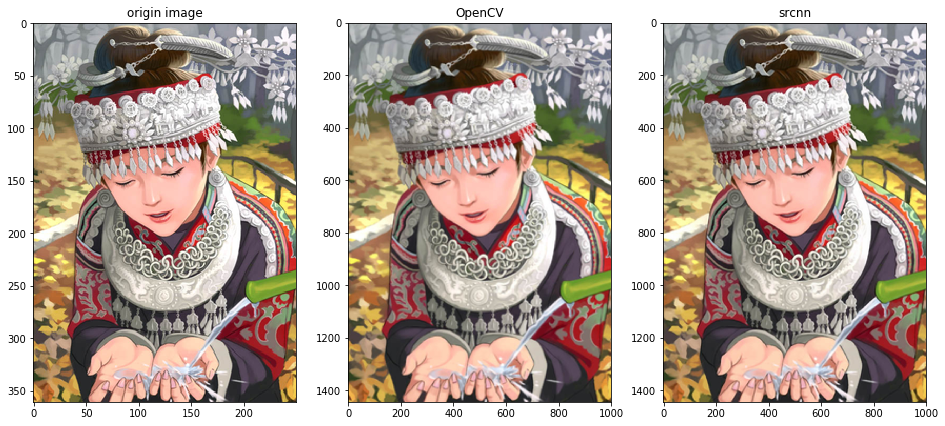

In [107]:
# display image
pltShow = True

if pltShow:    
    plt.figure(num='comparison',figsize=(16,16))

    plt.subplot(1,3,1)
    plt.title('origin image')
    plt.imshow(im1)

    plt.subplot(1,3,2)
    plt.title('OpenCV')
    plt.imshow(im2)

    plt.subplot(1,3,3)
    plt.title("srcnn")
    plt.imshow(im3)

In [108]:
tick2 = cv2.getTickCount()
tick = math.floor( ((tick2 - tick1) * 1000) / cv2.getTickFrequency())

if tick >= 60000:
    mins = math.floor(tick / 60000)
    secs = math.floor((tick - mins * 60000) / 1000)
    msec = tick - mins * 60000 - secs * 1000
    print("Inference processed time: " + str(mins) + " mins " + str(secs) + " secs " + str(msec) + " ms")
elif tick >= 1000:
    secs = math.floor(tick / 1000)
    msec = tick - secs * 1000
    print("Inference processed time: " + str(secs) + " secs " + str(msec) + " ms")
else:
    print("Inference processed time: " + str(tick) + " ms")

Inference processed time: 37 secs 786 ms
